## Get first appearance of covid per country

In [1]:
import pandas as pd

def create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Copy the first four columns to a new DataFrame
    new_df = df.iloc[:, :4].copy()
    
    # Initialize a list to store the new 'first_occurrence' column
    first_occurrence = []
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        found = False
        # Iterate over the columns, skipping the first four
        for col in df.columns[4:]:
            value = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(value) and value != 0:
                first_occurrence.append(col)
                found = True
                break
        if not found:
            first_occurrence.append(None)
    
    # Add the new column to the new DataFrame
    new_df['first_occurrence'] = first_occurrence
    
    # Save the new DataFrame to a new CSV file
    new_df.to_csv(output_file_path, index=False)

# Example usage
csv_file_path = './data/time_series_covid19_confirmed_global.csv'
output_file_path = './data/covidAppearance.csv'
create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path)

## Order countries by date of Covid first appearance

In [2]:
csv_file_path = './data/covidAppearance.csv'
output_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
df.sort_values(by=df.columns[4], inplace=True)

df.to_csv(output_file_path, index=False)

C:\Users\Adminj\AppData\Local\Temp\ipykernel_15104\2227610817.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')


## Histogram with nr. of countries with first Covid appearance per date

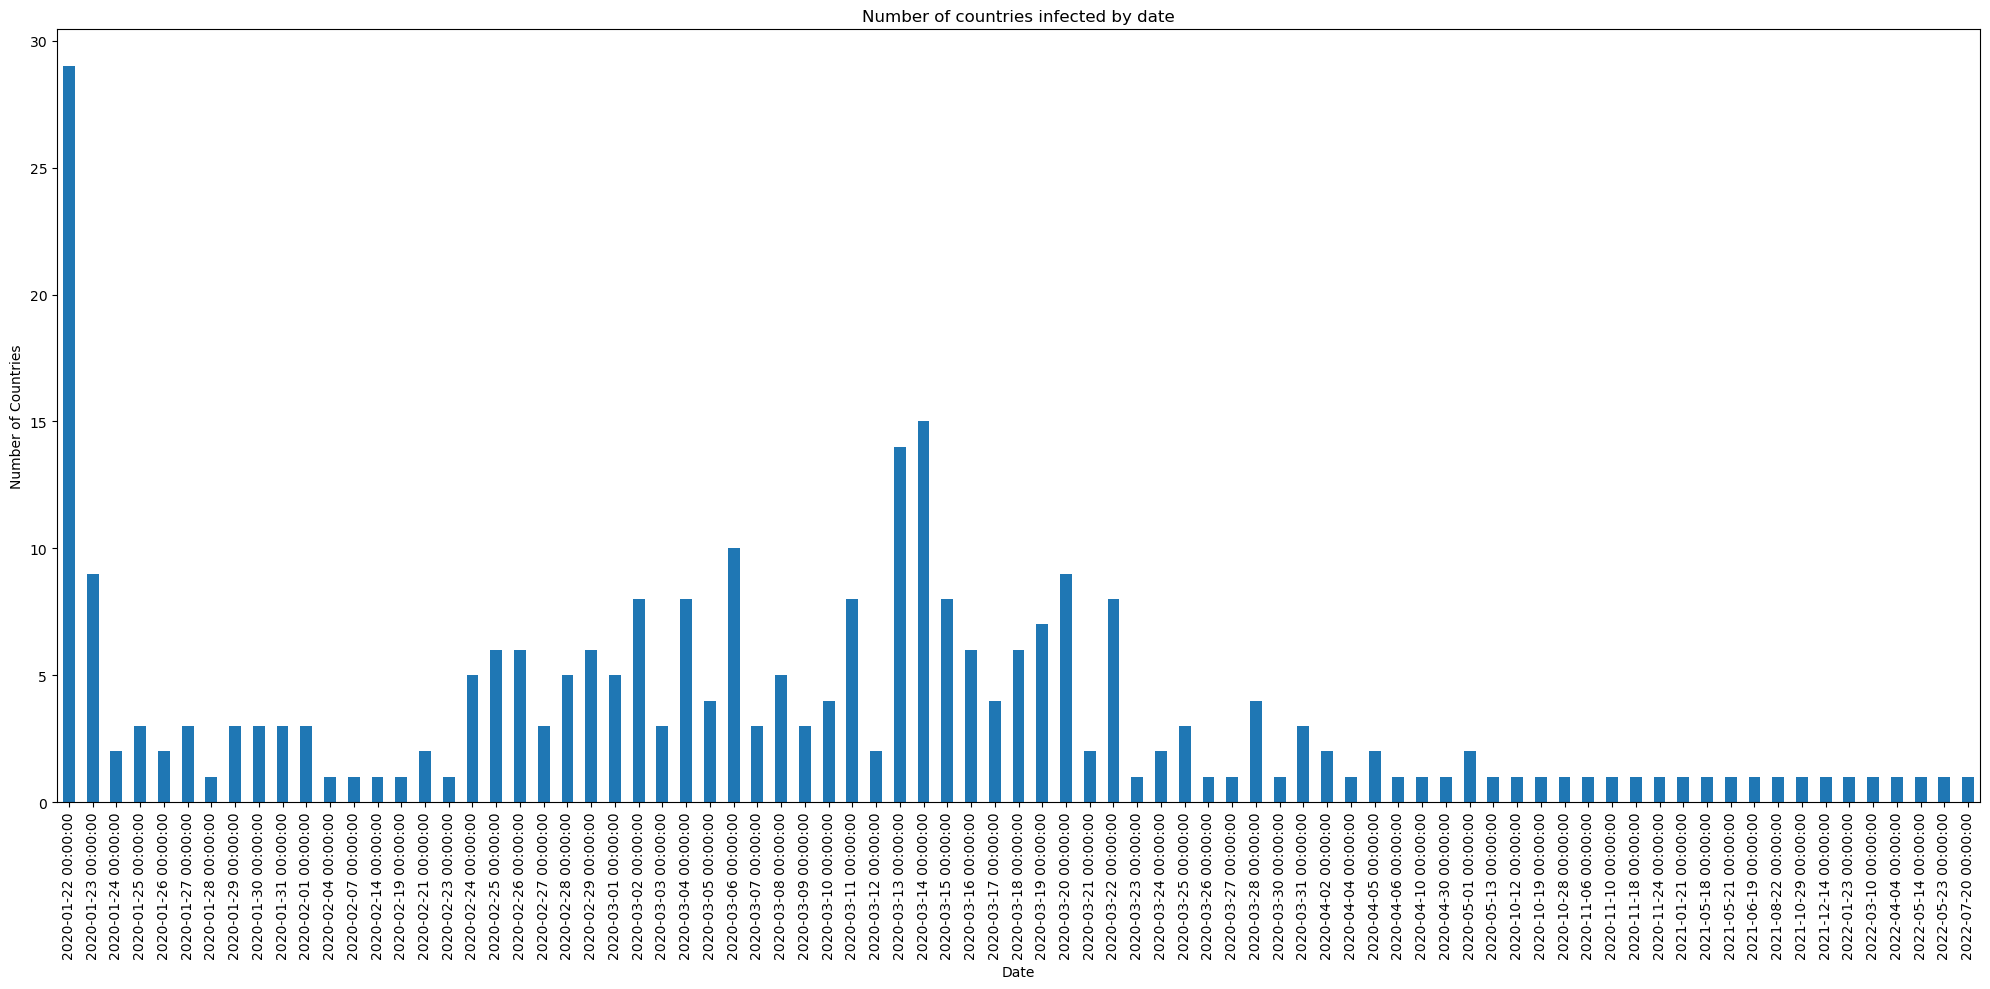

In [7]:
import matplotlib.pyplot as plt

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
    
# Count the occurrences of each date
date_counts = df.iloc[:, 4].value_counts().sort_index()
    
# Plot the histogram
plt.figure(figsize=(20, 10))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Countries')
plt.title('Number of countries infected by date')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Create Covid graph

In [1]:
import pandas as pd
# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

print(df.columns)

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'first_occurrence'], dtype='object')


# If Nan it probably means that there was no covid infection there (based on airports should be reported last?; provinces/states could be deleted?)

In [10]:
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

print(df[pd.isna(df['first_occurrence'])])

      Province/State  Country/Region      Lat    Long first_occurrence
288  Channel Islands  United Kingdom  49.3723 -2.3644              NaN


In [20]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.express import colors
from plotly.colors import sample_colorscale

# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
#df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

# Create a graph
G = nx.Graph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['Country/Region'], province_state=row['Province/State'], first_case_date=row['first_occurrence'], Lat = row['Lat'], Long = row['Long'])



# Group countries by their first infection date and add edges between countries with the same date
grouped = df.groupby('first_occurrence')['Country/Region'].apply(list)
for date, countries in grouped.items():
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            G.add_edge(countries[i], countries[j], date=date)


# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Plot the graph
# Create node trace for scattergeo
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date']}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes], #.date()
    mode='markers',
    marker=dict(
        size=[1 for node in G.nodes],
        color=[color_map[G.nodes[node]['first_case_date']] for node in G.nodes],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

"""
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date'].date()}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes],
    mode='markers+text',
    marker=dict(size=[1 for node in G.nodes], color='blue', opacity=0.7),
    textposition="top center"
)
"""

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['Long'], G.nodes[edge[0]]['Lat']
    x1, y1 = G.nodes[edge[1]]['Long'], G.nodes[edge[1]]['Lat']
    #print(edge('date'))
    edge_color = color_map[G.nodes[edge[0]]['first_case_date']]
    edge_trace = go.Scattergeo(
        lon=[x0, x1, None],
        lat=[y0, y1, None],
        mode='lines',
        line=dict(width=0.5, color=edge_color),#dict(width=0.5, color='gray'),
        opacity=0.5
    )
    edge_traces.append(edge_trace)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace])

fig.update_layout(
    title='COVID-19 First Case Connections on World Map',
    showlegend=False,
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

fig.show()

In [11]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.colors import sample_colorscale

# Use the correct renderer for your environment
#pio.renderers.default = 'notebook'  # Use 'notebook' for Jupyter Notebook, 'browser' for others

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

df = df.dropna(subset=['first_occurrence'])

# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Create a scatter plot for nodes
node_trace = go.Scattergeo(
    lon=df['Long'],
    lat=df['Lat'],
    text=[f"{country}<br>First Case: {first_case}<br>Province or state: {provState}" for country, first_case, provState in zip(df['Country/Region'], df['first_occurrence'], df['Province/State'])],
    mode='markers',
    marker=dict(
        size=[(max(unique_dates) - first_case).days / 100 for first_case in df['first_occurrence']],  # Adjust size based on date difference
        color=[color_map[first_case] for first_case in df['first_occurrence']],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

# Create layout
layout = go.Layout(
    title='COVID-19 First Case Distribution',
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

# Create the figure
fig = go.Figure(data=node_trace, layout=layout)

# Show the figure
fig.show()

---

## Airport data (Create graph out of airports and routes)

In [31]:
import pandas as pd
import numpy as np
import igraph as ig
import pickle
import pycountry
import os
import matplotlib.pyplot as plt

In [32]:
airports_df = pd.read_csv('./data/airports.csv', sep=',', engine='python')
airports_df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [33]:
routes_df = pd.read_csv('./data/routes.csv', sep=',', engine='python')
routes_df.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


### Keep only EU countries (only if needed)

In [ ]:
def is_eu(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_2 in ('AD', 'AL', 'AM', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 
                                   'DE', 'DK', 'EE', 'ES', 'FI', 'FO', 'FR', 'GB', 'GE', 'GI', 'GR', 'HR', 
                                   'HU', 'IE', 'IS', 'IT', 'KZ', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 
                                   'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 
                                   'SM', 'TR', 'UA', 'VA')
    except:
        return False

In [ ]:
airports_df = airports_df[[is_eu(r['Country']) for _, r in airports_df.iterrows()]]
airports_df = airports_df.reset_index(drop=True)
airports_df.head()

### Create graph

In [34]:
graph = ig.Graph(directed=True)
id2index_map = {}

for index, row in airports_df.iterrows():
    id2index_map[row['Airport ID']] = index
    graph.add_vertex(name=row['Name'], ID=row['Airport ID'], lat=row['Latitude'], lon=row['Longitude'])

In [35]:
edges = []
for index, row in routes_df.iterrows():
    if not row['Source airport ID'].strip().isdigit() or not row['Destination airport ID'].strip().isdigit():
        print("not an number:", row['Source airport ID'].strip().isdigit(), row['Destination airport ID'].strip().isdigit())
        continue
    
    aid = int(row['Source airport ID'])
    aid2 = int(row['Destination airport ID'])
    if 1328 in (aid, aid2):
        print(aid, aid2)
        
    if aid not in id2index_map or aid2 not in id2index_map:
        print("dont exist:", aid, aid2)
        continue
        
    edges.append((id2index_map[aid], id2index_map[aid2]))

graph.add_edges(edges)

not an number: True False
not an number: False True
not an number: True False
not an number: False True
dont exist: 3531 7167
dont exist: 3531 7168
dont exist: 3531 7164
dont exist: 3531 7163
dont exist: 7167 7176
dont exist: 7168 7173
dont exist: 7164 7165
dont exist: 7173 7172
dont exist: 7144 7145
dont exist: 7144 3808
dont exist: 7145 7144
dont exist: 7145 7147
dont exist: 7145 3808
dont exist: 7147 7145
dont exist: 7147 3808
dont exist: 3808 7144
dont exist: 3808 7145
dont exist: 3808 7147
dont exist: 5475 3376
dont exist: 8858 3369
dont exist: 3369 8858
dont exist: 3376 5475
dont exist: 5965 7215
dont exist: 7215 3423
not an number: True False
not an number: False True
dont exist: 3417 7119
dont exist: 7119 6712
dont exist: 3832 7112
dont exist: 3832 9741
dont exist: 3832 7113
dont exist: 7246 7110
dont exist: 7110 3832
dont exist: 7112 3832
dont exist: 9741 3832
dont exist: 9741 7115
dont exist: 7113 3832
dont exist: 7115 9741
dont exist: 7217 7218
dont exist: 4385 7094
dont exi

In [37]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

'Nodes: 7698, Edges: 66771'

### Delete zero degree nodes (cant make predictions if airport has no connections)

In [38]:
nodes_with_degree_zero = [vertex for vertex, degree in enumerate(graph.degree()) if degree == 0]
graph.delete_vertices(nodes_with_degree_zero)
len(nodes_with_degree_zero)

4484

In [39]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

'Nodes: 3214, Edges: 66771'

### Keep only largest connected component

In [40]:
sccs = graph.connected_components(mode='weak')
print(len(sccs))


# Get the sizes of each component
component_sizes = sccs.sizes()

for index in range(len(sccs)):
    print("Component:", index, "size:", component_sizes[index])


lcc = sccs.giant()
g = lcc

f'Nodes: {g.vcount()}, Edges: {g.ecount()}'


7
Component: 0 size: 3188
Component: 1 size: 10
Component: 2 size: 4
Component: 3 size: 4
Component: 4 size: 2
Component: 5 size: 2
Component: 6 size: 4


'Nodes: 3188, Edges: 66725'

### Change to directed graph since multigraph doesnt add value (allready connected)

In [46]:
from igraph import Graph


# Initialize a new directed graph
digraph = Graph(directed=True)
for v in g.vs:
    digraph.add_vertex(**v.attributes())

# Add edges to the new graph, avoiding duplicates
existing_edges = set()
for edge in g.es:
    source = edge.source
    target = edge.target
    if (source, target) not in existing_edges:
        digraph.add_edge(source, target)
        existing_edges.add((source, target))



f'Nodes: {digraph.vcount()}, Edges: {digraph.ecount()}'

#for node in digraph.vs:
#    print(node['lat'])

#print(g["lat"])

g = digraph


### Save graph

In [47]:
with open("./data/graphWorld.pickle", "wb") as f:
    pickle.dump(g, f)

### Draw on world map (Not sure if good visualization)

In [2]:
import pickle

with open("./data/graphWorld.pickle", "rb") as f:
    g = pickle.load(f)
    
g.vcount(), g.ecount(), g.is_directed()

(3188, 36861, True)

In [64]:
lats, lons, sizes = [], [], []
for node in g.vs:
    lats.append(node['lat'])
    lons.append(node['lon'])
    sizes.append(g.degree(node) / 5)

C:\Users\Adminj\AppData\Local\Temp\ipykernel_57064\3270528285.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


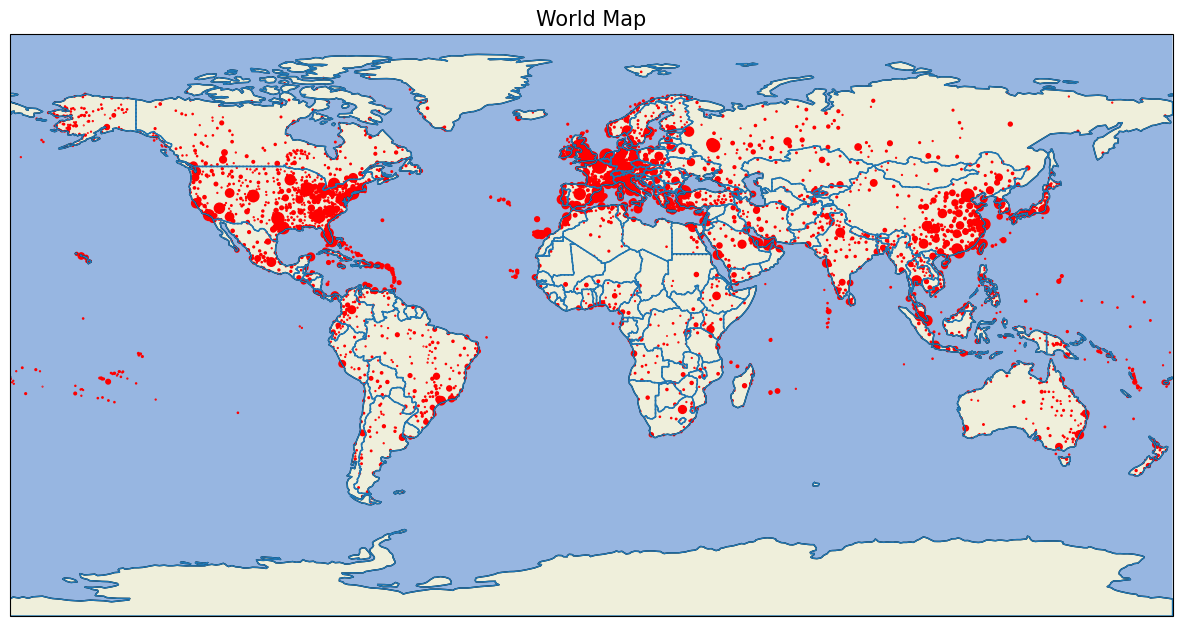

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world map from geopandas datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a figure and axis using cartopy with a specific projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographical features using cartopy
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the world map
world.boundary.plot(ax=ax, linewidth=1)

# Add a title
ax.set_title('World Map', fontsize=15)

ax.scatter(lons, lats, s=sizes, color='red', transform=ccrs.PlateCarree())

# Display the plot
plt.show()

---

## Perform node importance analysis

In [3]:
import networkx as nx
import utils

import igraph as ig
import networkx as nx


G = g.to_networkx()

G = nx.convert_node_labels_to_integers(G, label_attribute=None)

#G = nx.DiGraph(G)

print(G)

DiGraph with 3188 nodes and 36861 edges


In [4]:
print(G.nodes[0])

{'ID': 1, 'lat': -6.0816898345900015, 'lon': 145.391998291, 'name': 'Goroka Airport', '_igraph_index': 0}


### Network info

In [23]:
import utils

utils.info(G, None, 10000) #Distance ne more avg (vsaj ne cez vse) ker ni strongly connected graf

     DiGraph | ''
       Nodes | 3,188 (iso=0)
       Edges | 36,861 (loop=1)
      Degree | 11.56 max(in=238, out=239)
         LCC | 100.0% (n=1)
  Clustering | 0.4798



### Degree Centrality

In [5]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.149671 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.147474 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.145278 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.141512 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.135864 | 'Hartsfield Jackson Atlanta International Airport' (In-deg:216, Out-deg:217), ID:1802
    0.128334 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.128020 | 'Beijing Capital International Airport' (In-deg:204, Out-deg:204), ID:1635
    0.119234 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
    0.117666 | 'Domodedovo International Airport' (In-deg:188, Out-deg:187), ID:2007
    0.116724 | 'Dallas Fort Worth International Airport' (In-deg:185, Out-deg:187), ID:1793
    0.114214 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.106683 | 'London Heathrow Airport' (In-d

### In-degree centrality

In [6]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.in_degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.074678 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.073110 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.072482 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.071227 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.067775 | 'Hartsfield Jackson Atlanta International Airport' (In-deg:216, Out-deg:217), ID:1802
    0.064010 | 'Beijing Capital International Airport' (In-deg:204, Out-deg:204), ID:1635
    0.063696 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.059303 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
    0.058990 | 'Domodedovo International Airport' (In-deg:188, Out-deg:187), ID:2007
    0.058048 | 'Dallas Fort Worth International Airport' (In-deg:185, Out-deg:187), ID:1793
    0.056166 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.053342 | 'London Heathrow Airport' (In-d

### Out-degree centrality

In [7]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.out_degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.074992 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.074365 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.072796 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.070286 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.068089 | 'Hartsfield Jackson Atlanta International Airport' (In-deg:216, Out-deg:217), ID:1802
    0.064638 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.064010 | 'Beijing Capital International Airport' (In-deg:204, Out-deg:204), ID:1635
    0.059931 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
    0.058676 | 'Domodedovo International Airport' (In-deg:188, Out-deg:187), ID:2007
    0.058676 | 'Dallas Fort Worth International Airport' (In-deg:185, Out-deg:187), ID:1793
    0.058048 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.053342 | 'London Heathrow Airport' (In-d

### Clustering Coefficients

In [8]:
top_clustering = utils.top_nodes(G, nx.clustering(G), 'clustering')

  Centrality | 'clustering'
    1.000000 | 'Regina International Airport' (In-deg:9, Out-deg:9), ID:72
    1.000000 | 'Saskatoon John G. Diefenbaker International Airport' (In-deg:9, Out-deg:9), ID:102
    1.000000 | 'Cozumel International Airport' (In-deg:9, Out-deg:9), ID:815
    1.000000 | 'Tabuk Airport' (In-deg:7, Out-deg:7), ID:978
    1.000000 | 'Rogue Valley International Medford Airport' (In-deg:7, Out-deg:7), ID:2060
    1.000000 | 'Abraham González International Airport' (In-deg:6, Out-deg:6), ID:812
    1.000000 | 'Francisco Sarabia International Airport' (In-deg:6, Out-deg:6), ID:847
    1.000000 | 'Monterey Peninsula Airport' (In-deg:6, Out-deg:6), ID:1950
    1.000000 | 'Santa Barbara Municipal Airport' (In-deg:6, Out-deg:6), ID:1951
    1.000000 | 'Charlottesville Albemarle Airport' (In-deg:6, Out-deg:6), ID:1993
    1.000000 | 'Grand Junction Regional Airport' (In-deg:6, Out-deg:6), ID:2034
    1.000000 | 'Roberts Field' (In-deg:6, Out-deg:6), ID:2061
    1.000000 | 'Q

### mu-corrected clustering coefficient

In [9]:
top_mu_clustering = utils.top_nodes(G, {i: c * (G.degree(i) - 1) for i, c in nx.clustering(G).items()}, '~μ-clustering')

  Centrality | '~μ-clustering'
   77.321529 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:159, Out-deg:157), ID:706
   76.963235 | 'Zürich Airport' (In-deg:136, Out-deg:137), ID:758
   76.051182 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
   75.742256 | 'Barcelona International Airport' (In-deg:163, Out-deg:163), ID:570
   74.889205 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
   73.880000 | 'Geneva Cointrin International Airport' (In-deg:100, Out-deg:101), ID:755
   73.586380 | 'London Heathrow Airport' (In-deg:170, Out-deg:170), ID:255
   73.436432 | 'Dublin Airport' (In-deg:144, Out-deg:144), ID:288
   71.490542 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
   71.155863 | 'Copenhagen Kastrup Airport' (In-deg:120, Out-deg:121), ID:295
   70.238407 | 'Malpensa International Airport' (In-deg:111, Out-deg:107), ID:691
   69.962756 | 'Brussels Airport' (In-deg:147, Out-deg:146), ID:184
   69.734615 | 'Václav Havel Airport Prague' (In-deg:9

### Eigenvector Centrality

In [10]:
def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

top_eigenVect = utils.top_nodes(G, eigenvector_centrality(G), 'eigenvector')

  Centrality | 'eigenvector'
   25.548748 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
   25.170530 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
   24.540343 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
   22.958023 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
   21.014830 | 'London Heathrow Airport' (In-deg:170, Out-deg:170), ID:255
   20.785017 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:159, Out-deg:157), ID:706
   19.892745 | 'Barcelona International Airport' (In-deg:163, Out-deg:163), ID:570
   19.725382 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
   19.539662 | 'Zürich Airport' (In-deg:136, Out-deg:137), ID:758
   19.009547 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:156, Out-deg:158), ID:578
   18.692054 | 'Brussels Airport' (In-deg:147, Out-deg:146), ID:184
   18.036107 | 'Dublin Airport' (In-deg:144, Out-deg:144), ID:288
   17.819335 | 'Düsseldorf Airport' (In-deg:1

In [11]:
top_eigenVect = utils.top_nodes(G, nx.eigenvector_centrality(G), 'eigenvector')

  Centrality | 'eigenvector'
    0.165988 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.165793 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.159272 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.149033 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
    0.136871 | 'London Heathrow Airport' (In-deg:170, Out-deg:170), ID:255
    0.135915 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:159, Out-deg:157), ID:706
    0.129525 | 'Barcelona International Airport' (In-deg:163, Out-deg:163), ID:570
    0.129509 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.126253 | 'Zürich Airport' (In-deg:136, Out-deg:137), ID:758
    0.123318 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:156, Out-deg:158), ID:578
    0.122436 | 'Brussels Airport' (In-deg:147, Out-deg:146), ID:184
    0.117392 | 'Dublin Airport' (In-deg:144, Out-deg:144), ID:288
    0.116062 | 'Düsseldorf Airport' (In-deg:1

### PageRank

In [12]:
def pagerank(G, alpha = 0.85, eps = 1e-6):
    P = [1 / len(G)] * len(G)
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores and the number of their out-links
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]]) for i in G.nodes()]
        # Calculate a damping factor based on the 'alpha' parameter
        u = sum(U)
        # Apply the damping factor and ensure that the scores sum up to 1
        U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

top_pagerank = utils.top_nodes(G, pagerank(G), 'pagerank')

  Centrality | 'pagerank'
    0.003241 | 'Domodedovo International Airport' (In-deg:188, Out-deg:187), ID:2007
    0.003228 | 'Denver International Airport' (In-deg:167, Out-deg:168), ID:1845
    0.003068 | 'Hartsfield Jackson Atlanta International Airport' (In-deg:216, Out-deg:217), ID:1802
    0.003024 | 'Dallas Fort Worth International Airport' (In-deg:185, Out-deg:187), ID:1793
    0.002827 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.002651 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.002561 | 'El Dorado International Airport' (In-deg:74, Out-deg:74), ID:1257
    0.002338 | 'Sydney Kingsford Smith International Airport' (In-deg:83, Out-deg:85), ID:1632
    0.002264 | 'Jorge Newbery Airpark' (In-deg:42, Out-deg:43), ID:1125
    0.002219 | 'Tokyo Haneda International Airport' (In-deg:74, Out-deg:73), ID:1095
    0.002198 | 'Ninoy Aquino International Airport' (In-deg:78, Out-deg:78), ID:1108
    0.002146 | 'George Bus

In [13]:
top_pagerank = utils.top_nodes(G, nx.pagerank(G), 'pagerank')

  Centrality | 'pagerank'
    0.004962 | 'Hartsfield Jackson Atlanta International Airport' (In-deg:216, Out-deg:217), ID:1802
    0.004549 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.004519 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.004466 | 'Denver International Airport' (In-deg:167, Out-deg:168), ID:1845
    0.004446 | 'Dallas Fort Worth International Airport' (In-deg:185, Out-deg:187), ID:1793
    0.004247 | 'Domodedovo International Airport' (In-deg:188, Out-deg:187), ID:2007
    0.004171 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.004052 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.003983 | 'Beijing Capital International Airport' (In-deg:204, Out-deg:204), ID:1635
    0.003841 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.003739 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.003737 | 'George Bush I

### Closeness Centrality (probably not good for weak graph since it calculates distances for all nodes to all other nodes)

In [14]:
top_closeness = utils.top_nodes(G, nx.closeness_centrality(G), 'closeness')

  Centrality | 'closeness'
    0.408923 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.406442 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.404251 | 'London Heathrow Airport' (In-deg:170, Out-deg:170), ID:255
    0.399077 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.398874 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.392315 | 'Los Angeles International Airport' (In-deg:147, Out-deg:148), ID:1708
    0.392071 | 'John F Kennedy International Airport' (In-deg:160, Out-deg:162), ID:1862
    0.386916 | 'Lester B. Pearson International Airport' (In-deg:146, Out-deg:147), ID:125
    0.386679 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.385921 | 'Munich Airport' (In-deg:189, Out-deg:191), ID:196
    0.383711 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.383384 | 'Beijing Capital International Airport' (In-deg:204, Ou

### Betweenness Centrality

In [15]:
nodesBetweenness = utils.top_nodes(G, nx.betweenness_centrality(G), 'betweenness')#, n=len(G))

  Centrality | 'betweenness'
    0.064432 | 'Charles de Gaulle International Airport' (In-deg:233, Out-deg:237), ID:628
    0.062071 | 'Los Angeles International Airport' (In-deg:147, Out-deg:148), ID:1708
    0.059065 | 'Dubai International Airport' (In-deg:179, Out-deg:185), ID:1010
    0.055439 | 'Ted Stevens Anchorage International Airport' (In-deg:34, Out-deg:34), ID:1853
    0.053150 | 'Frankfurt am Main Airport' (In-deg:238, Out-deg:239), ID:191
    0.050192 | 'Beijing Capital International Airport' (In-deg:204, Out-deg:204), ID:1635
    0.046417 | 'Chicago O'Hare International Airport' (In-deg:203, Out-deg:206), ID:1877
    0.045049 | 'Lester B. Pearson International Airport' (In-deg:146, Out-deg:147), ID:125
    0.044962 | 'Amsterdam Airport Schiphol' (In-deg:231, Out-deg:232), ID:282
    0.042435 | 'Atatürk International Airport' (In-deg:227, Out-deg:224), ID:770
    0.042142 | 'Guarulhos - Governador André Franco Montoro International Airport' (In-deg:90, Out-deg:92), ID:118

### Testing node order by degree (in-degree probably more important since youre interested in Covid coming in; But other ppl could travel to an airport by car (in) to continue by plane (out))

In [16]:
degrees = dict(G.degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:191, Name:Frankfurt am Main Airport  - Degree: 477
ID:628, Name:Charles de Gaulle International Airport  - Degree: 470
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 463
ID:770, Name:Atatürk International Airport  - Degree: 451
ID:1802, Name:Hartsfield Jackson Atlanta International Airport  - Degree: 433
ID:1877, Name:Chicago O'Hare International Airport  - Degree: 409
ID:1635, Name:Beijing Capital International Airport  - Degree: 408
ID:196, Name:Munich Airport  - Degree: 380
ID:2007, Name:Domodedovo International Airport  - Degree: 375
ID:1793, Name:Dallas Fort Worth International Airport  - Degree: 372
ID:1010, Name:Dubai International Airport  - Degree: 364
ID:255, Name:London Heathrow Airport  - Degree: 340
ID:1737, Name:George Bush Intercontinental Houston Airport  - Degree: 337
ID:1845, Name:Denver International Airport  - Degree: 335
ID:253, Name:London Gatwick Airport  - Degree: 330


In [17]:
degrees = dict(G.in_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:191, Name:Frankfurt am Main Airport  - Degree: 238
ID:628, Name:Charles de Gaulle International Airport  - Degree: 233
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 231
ID:770, Name:Atatürk International Airport  - Degree: 227
ID:1802, Name:Hartsfield Jackson Atlanta International Airport  - Degree: 216
ID:1635, Name:Beijing Capital International Airport  - Degree: 204
ID:1877, Name:Chicago O'Hare International Airport  - Degree: 203
ID:196, Name:Munich Airport  - Degree: 189
ID:2007, Name:Domodedovo International Airport  - Degree: 188
ID:1793, Name:Dallas Fort Worth International Airport  - Degree: 185
ID:1010, Name:Dubai International Airport  - Degree: 179
ID:255, Name:London Heathrow Airport  - Degree: 170
ID:1737, Name:George Bush Intercontinental Houston Airport  - Degree: 168
ID:1845, Name:Denver International Airport  - Degree: 167
ID:253, Name:London Gatwick Airport  - Degree: 165


In [18]:
degrees = dict(G.out_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:191, Name:Frankfurt am Main Airport  - Degree: 239
ID:628, Name:Charles de Gaulle International Airport  - Degree: 237
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 232
ID:770, Name:Atatürk International Airport  - Degree: 224
ID:1802, Name:Hartsfield Jackson Atlanta International Airport  - Degree: 217
ID:1877, Name:Chicago O'Hare International Airport  - Degree: 206
ID:1635, Name:Beijing Capital International Airport  - Degree: 204
ID:196, Name:Munich Airport  - Degree: 191
ID:1793, Name:Dallas Fort Worth International Airport  - Degree: 187
ID:2007, Name:Domodedovo International Airport  - Degree: 187
ID:1010, Name:Dubai International Airport  - Degree: 185
ID:255, Name:London Heathrow Airport  - Degree: 170
ID:1737, Name:George Bush Intercontinental Houston Airport  - Degree: 169
ID:1845, Name:Denver International Airport  - Degree: 168
ID:253, Name:London Gatwick Airport  - Degree: 165
